In [17]:
razor.api.libraries('fastparquet')


Name,Technology,Install Status,Created by,Created on,Modified by,Modified on
fastparquet,PYTHON,INSTALLED,Ayan Basak,"Sep 25, 2020",Ayan Basak,"Sep 25, 2020"


In [18]:
import razor


In [19]:
config = {'cpu': 8 , 'ram': 36000}

In [20]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [21]:
import razor.flow as rf
from razor.api import datasources
from razor import project_space_path
import razor
from razor import Technology, LibraryMode


In [22]:
import typing as t

# Light GBM modelling

In [23]:
lib1 = razor.api.libraries(name='lightgbm').artifact()

In [24]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cpu'], memory=config['ram']))
class Train:
#     config: t.Any
    
    __libs__ = [lib1]
    
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.LAGS     = project_space_path('M5Forecasting/lags_df_28.pkl')
        self.MEAN_ENC = project_space_path('M5Forecasting/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = '../input/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]
        
        self.remove_features = ['id','state_id','store_id',
                           'date','wm_yr_wk','d', self.TARGET]
        self.mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                           'enc_dept_id_mean','enc_dept_id_std',
                           'enc_item_id_mean','enc_item_id_std'] 

            
    def seed_everything(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)


    ## Multiprocess Runs
    def df_parallelize_run(self, func, t_split):
        num_cores = np.min([self.N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df

    def get_data_by_store(self, store):

        # Read and contact basic feature
        df1 = pd.read_pickle(self.BASE)
#         df1 = df1[df1['store_id']==store]
        df2 = pd.read_pickle(self.PRICE).iloc[:,2:]
#         df2 = df2[df2['store_id']==store]
        df3 = pd.read_pickle(self.CALENDAR).iloc[:,2:]
        df = pd.concat([df1, df2, df3],
                        axis=1)

        # Leave only relevant store
        df = df[df['store_id']==store]

        # With memory limits we have to read 
        # lags and mean encoding features
        # separately and drop items that we don't need.
        # As our Features Grids are aligned 
        # we can use index to keep only necessary rows
        # Alignment is good for us as concat uses less memory than merge.
        df2 = pd.read_pickle(self.MEAN_ENC)[self.mean_features]
        df2 = df2[df2.index.isin(df.index)]

        df = pd.concat([df, df2], axis=1)
        del df2 # to not reach memory limit 
        gc.collect()

        df3 = pd.read_pickle(self.LAGS).iloc[:,3:]
        df3 = df3[df3.index.isin(df.index)]


        df = pd.concat([df, df3], axis=1)
        del df3 # to not reach memory limit 
        gc.collect()

        # Create features list
        features = [col for col in list(df) if col not in self.remove_features]
        df = df[['id','d',self.TARGET]+features]

        # Skipping first n rows
        df = df[df['d']>=self.START_TRAIN].reset_index(drop=True)

        return df, features

    # Recombine Test set after training
    def get_base_test(self):
        base_test = pd.DataFrame()

        for store_id in self.STORES_IDS:
            temp_df = pd.read_pickle('test_'+store_id+'.pkl')
            temp_df['store_id'] = store_id
            base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

        return base_test


    ########################### Helper to make dynamic rolling lags
    #################################################################################
    def make_lag(self, LAG_DAY):
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'sales_lag_{str(LAG_DAY)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
        return lag_df[[col_name]]


    def make_lag_roll(self, LAG_DAY):
        shift_day = LAG_DAY[0]
        roll_wind = LAG_DAY[1]
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
        return lag_df[[col_name]]
    
    def run(self):
                         
        import logging


        import lightgbm as lgb
        lgb_params = {
                            'boosting_type': 'gbdt',
                            'objective': 'tweedie',
                            'tweedie_variance_power': 1.1,
                            'metric': 'rmse',
                            'subsample': 0.5,
                            'subsample_freq': 1,
                            'learning_rate': 0.03,
                            'num_leaves': 2**11-1,
                            'min_data_in_leaf': 2**12-1,
                            'feature_fraction': 0.5,
                            'max_bin': 100,
                            'n_estimators': 1400,
                            'boost_from_average': False,
                            'verbose': -1,
                        } 


                ########################### Vars
        #################################################################################
        VER = 1                          # Our model version
        SEED = 42                      
        self.seed_everything(SEED)      
        lgb_params['seed'] = SEED        

        #FEATURES to remove
        ## These features lead to overfit
        ## or values not present in test set



#         base_df = pd.read_csv(project_space_path("M5Forecasting/sales_train_validation.csv"))
#         price_df = pd.read_csv(project_space_path("M5Forecasting/sell_prices.csv"))
#         calendar_df = pd.read_csv(project_space_path("M5Forecasting/calendar.csv"))

#         base_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
#         price_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
#         calendar_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))

        ROLS_SPLIT = []
        
        for i in [1,7,14]:
            for j in [7,14,30,60]:
                ROLS_SPLIT.append([i,j])


        if self.USE_AUX:
            lgb_params['n_estimators'] = 2

        

                ########################### Train Models
        #################################################################################
        for store_id in self.STORES_IDS:
            logging.info('Train')
            logging.info(store_id)

            # Get grid for current store
            grid_df, features_columns = self.get_data_by_store(store_id)
            
            logging.info("Loaded grid Data")

            # Masks for 
            # Train (All data less than 1913)
            # "Validation" (Last 28 days - not real validatio set)
            # Test (All data greater than 1913 day, 
            #       with some gap for recursive features)
            train_mask = grid_df['d']<=self.END_TRAIN
            valid_mask = train_mask&(grid_df['d']>(self.END_TRAIN-self.P_HORIZON))
            preds_mask = grid_df['d']>(self.END_TRAIN-100)

            train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                               label=grid_df[train_mask][self.TARGET])
            
#             train_data.save_binary(project_space_path("M5Forecasting/train_data.bin"))
#             train_data = lgb.Dataset(project_space_path("M5Forecasting/train_data.bin"))

            valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                               label=grid_df[valid_mask][self.TARGET])

            # Saving part of the dataset for later predictions
            # Removing features that we need to calculate recursively 
            grid_df = grid_df[preds_mask].reset_index(drop=True)
            keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
            grid_df = grid_df[keep_cols]
            grid_df.to_pickle(project_space_path(f"M5Forecasting/test_{store_id}.pkl"))
            del grid_df
            gc.collect()

            # Launch seeder again to make lgb training 100% deterministic
            # with each "code line" np.random "evolves" 
            # so we need (may want) to "reset" it
            self.seed_everything(SEED)
            estimator = lgb.train(lgb_params,
                                  train_data,
                                  valid_sets = [valid_data],
                                  verbose_eval = 100,
                                  )


            model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
            pickle.dump(estimator, open(project_space_path(f"M5Forecasting/{model_name}"), 'wb'))

            # Remove temporary files and objects 
            # to free some hdd space and ram memory

#             os.remove()
            del train_data, valid_data, estimator
            gc.collect()

            # "Keep" models features for predictions
            MODEL_FEATURES = features_columns



In [25]:
train = Train()


In [26]:
p = rf.Pipeline("Train", targets=[train])  #preprocess


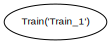

In [27]:
p

In [28]:
# lib1 = razor.api.libraries(name='lightgbm').artifact()


In [29]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [30]:
deployed_pipeline


PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='44a864ea-03bf-11eb-8704-0242ac110009', pipeline_name='Train', pipeline_run_id='2f5fbd43-83ef-48b7-a7fa-edad0b946360', pipeline_version=None, comment=None, created_on='2020-10-01T08:22:39.543+00:00', start_time=None, end_time=None, eta=0, run_at=1601540559543, run_duration=0, compute_time=0, wait_time=12, ran_by_user=RanByUser(user_name='souryadipta das', email='souryadipta.das@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='2f5fbd43-83ef-48b7-a7fa-edad0b946360', pipeline_name='Train', pipeline_status='IN_PROGRESS', block_id='3810c3a6-2ce9-4e62-b4f3-40efacad56c1', block_run_id='34967e04-de95-4574-870b-54d43e3b2ca7', block_name='Train_1', resource_spec=ResourceAllocated(cores=8, memory=36000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='3810c3a6-2ce9-4e62-b4f3-40efacad56c1', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-10-01T08:22:40.000+00:00')], run_number=203, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='3810c3a6-2ce9-4e62-b4f3-40efacad56c1', block_run_id='34967e04-de95-4574-870b-54d43e3b2ca7', block_name='Train_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-10-01T08:22:39.630+00:00', queued_at='2020-10-01T08:22:40.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=8, memory=36000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "44a864ea-03bf-11eb-8704-0242ac110009",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Train",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Train_1",\n      "id": "3810c3a6-2ce9-4e62-b4f3-40efacad56c1",\n      "artifact_id": null,\n      "class_name": "Train",\n      "code": "eJyVWc1zG8l1ny8AA5AEQZAiRWlXK2+0DtdecvktyWZpQ4GUVoYIySJ3FW1F1R6gBxiAAww0M5DIDaD1lr7Lo6okHh9sxymyypVLcktc5Wv8L/icVHJwfEguyS0Xb36vByBBidpKiEKj5/XrN93v+z3+UPvJT09L4i+YKNlOizerpW3bnOmbh8Ekc01rl7uGbzJv27RN32mwkm14XvjjcMqSgjFWN7aPWwv0Yqtq+9WGFwaav9s0AQxiW65RbYSWMmVpU1bC0q1YEHeKNbPkY/lJ2AmDBGPcKTEWFrzg7MWF4mxpvlQ0jYXZxcXl4oUFo1wsFpeW5szZ2eWLF8KCH97CrqkgxVjd4S3bxM5AxwPe053a1aKH6V2Bl8STa7i713gYnJtf5LNL5eL89IWLc8vTi3x+afrC3Pz56fnzy+bSeT5bLF0AWqa75VPT9apOQ+xcPl8yjdLs0vTi/DKfXixdNKYNHGi6ZBbnFpZmS3PL8wthywi0aqPqh+BTmpWrts3KrUbJB5Eu94YPuSeWAAZ0iHVZx3p803MON7fo4QnuO5WX8xK+iXwu95++xOVHMlcmpLbEZDypj2TMFMw0MVMxi4mZhllczGKYJcQsznWMCZ7EqPMUxiQfwJjigxgH/MG9oX2inOZDGIf9zN5IW6rJPD0h7ct8eJLWsv4oYNm9sX1J0MwKCid4BuM4H+HZx5I/AYwT3e/4hPRIWYtwT/JRPsaH+Qk+zgknUUkAOslP8kl+ip/mb/G3K3FATnFpUwqnCsHQxtIVxzVLhgcGVcJA/jAMvnUE9mF9adqr1pu2OV02P6y4Vc6ahuuzuZnmtv1/RZ7//yAvRMhvHUW2jYrHeJnNX4iW332Flmk0mNkoORxPwIuQYp5hm16YlzZ2E/m3XgQTMzMfVhvNlk/vNlo709By0/Zw6VMCk/lkUey+YVe5QZo1U/LuQ2E8H69iVR7mh61zkcIoeTW/mctUILK7ekduy3+p3NPA1PffD5SZ2TBQS44dPg2Dd1aqzV3fchrT4sXT84vT5QsXF3lx2Zi9yJcuhUFqxa56fsmpNy+F+XM5JU5EyBKDM8LAZ0jrZ1Zsp2TY3qWZPuxAwZHodORQaKrh1PAz+oM623XZg20IFNBh8IWVDB8ojPgUBuk+iOeTVRKAm80+nOF+0CFS1TfrryD1QITkwytkm65DToh5TaNkQqi+hTPduHXt6rXC6nWc8vLq5jqEc/PWtdw6mePq9fXC2iourF1fvboJyMb6aoGtF3JhEN9avXV1fSsMBjYx22Jbt1avFcIgiQ0H85vsYxD/7AbmiU8219nqJ3+KjU2v5VehA8lSs8VKTqvhY7nAcjdureMVKSCxjRtr69fxoDSJja5pcCbkndrcIix2bQ2LGvEb9FqN6r0WmJvc/PjalS22tnoHwAKLThxzjUYFiyl6ZJs3r1/DkYdds+7cN1nZNPyWCz0MhoSaHjyDrOaZdhl+yFqyTucTuRlJScup3keNy70P5tq4nNFoflaJyxlZw6erKN/7Cn/kjwcYuF3aNirkuAvkrhtGnebWaOtZ17cnKrZThCbRg3U1eNc1PnfcGaNZnSlBy

In [31]:
razor.api.engines('DS-engine').health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.104.139', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=6, available=10, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=6442450944.0, available=34359738368.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=13, available=19, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=71403831296.0, available=52076478464.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')])])

In [33]:
razor.api.engines('DS-engine').queue()

Block,Pipeline,Wait Time(hours:minutes:seconds)
